### 관련성 체크 추가

#### 1. Naive RAG수행
#### 2. 검색된 문서에 대한 관련성 체크 부분 추가

In [1]:
# 환경설정
from dotenv import load_dotenv
import os

# .env 파일 로드
load_dotenv()

from langchain_teddynote import logging

logging.langsmith("langgraph_study_2")

LangSmith 추적을 시작합니다.
[프로젝트명]
langgraph_study_2


In [2]:
# pdf 문서 로드
from pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [3]:
# state 정의
# State : Graph의 노드간 공유하는 상태를 정의함
# 일반적으로 TypeDict 형식을 사용함

from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

# GraphState 상태 정의
class GraphState(TypedDict):
    question : Annotated[str, "Question"] # 질문
    context : Annotated[str, "Context"] # 문서의 검색 결과
    answer : Annotated[str, "Answer"] # 답변
    message : Annotated[list, add_messages] # 메세지(누적되는 list)
    relevance : Annotated[str, "Relevance"] # 관련성

In [6]:
# 노드가 될 함수 정의

from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from utils import format_docs

# 문서 검색 노드
def retrieve_document(state : GraphState) -> GraphState:
    latest_question = state["question"] # 질문을 상태에서 가져옵니다.
    retrieved_docs = pdf_retriever.invoke(latest_question) # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = format_docs(retrieved_docs) # 검색된 문서를 형식화 합니다.
    return GraphState(context = retrieved_docs) # 검색된 문서를 context 키에 저장합니다.

# 답변 생성 노드
def llm_answer(state : GraphState) -> GraphState:
    latest_question = state["question"] # 질문을 상태에서 가져옵니다.
    context = state["context"] # 검색된 문서를 상태에서 가져옵니다.
    response = pdf_chain.invoke(
        {
            "question" : latest_question,
            "context" : context,
            "chat_history" : messages_to_history(state["message"])
        }
    ) # 체인을 호출하여 답변을 생성합니다.
    return GraphState(answer = response, messages = [("user", latest_question), ("assistant", response)])

# 관련성 체크 노드
def relevance_check(state : GraphState) -> GraphState:
    # 관련성 평가기를 생성
    question_retrieval_relvance = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # 관련성 체크를 실행("yes" or "no")
    response = question_retrieval_relvance.invoke(
        {"question" : state["question"], "context" : state["context"]}
    )

    print("==== [RELEVANCE CHECK] ====")
    print(response.score)

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt를 사용하여 수정할 수 있습니다. 자신만의 GroundednessChecker 만들어 사용할것
    return {"relevance" : response.score}

def is_relevant(state : GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


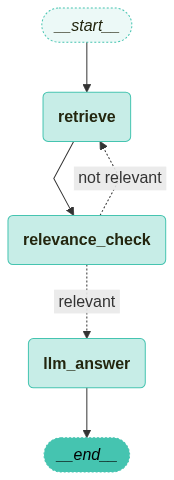

In [8]:
# 그래프 생성 : 현재의 State를 기반으로 다음에 실행한 node를 결정하는 기능 정의

from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

workflow = StateGraph(GraphState) # 그래프 생성

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("relevance_check", relevance_check)

# 엣지 정의
workflow.add_edge("retrieve", "relevance_check") # 검색 -> 관련성 체크
workflow.add_conditional_edges(
    "relevance_check", 
    is_relevant,
    {
        "relevant" : "llm_answer",
        "not relevant" : "retrieve",
    },
)
workflow.add_edge("llm_answer", END) # 답변 ->종료


# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인트 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

visualize_graph(app)

In [10]:
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재위 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question = "투자한 기업중에서 금액이 수익이 큰곳은 어디입니까?")

# 그래프 실행
try:
    invoke_graph(app, inputs, config, ["retrieve", "relevance_check","llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError : {recursion_error}")


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>투자하기로 하면서 오픈AI의 지분 49%를 확보했으며, 오픈AI는 마이크로소프트의 애저(Azure)
클라우드 플랫폼을 사용해 AI 모델을 훈련
£구글, 클라우드 경쟁력 강화를 위해 생성 AI 투자 확대
n 구글은 수익률이 높은 클라우드 컴퓨팅 시장에서 아마존과 마이크로소프트를 따라잡고자 생성 AI를
통한 기업 고객의 클라우드 지출 확대를 위해 AI 투자를 지속
∙ 구글은 앤스로픽 외에도 AI 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어
기업 허깅 페이스(Hugging Face)에도 투자</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>기업 허깅 페이스(Hugging Face)에도 투자
∙ 구글은 챗GPT의 기반 기술과 직접 경쟁할 수 있는 차세대 LLM ‘제미니(Gemini)’를 포함한 자체 AI
시스템 개발에도 수십억 달러를 투자했으며, 2024년 제미니를 출시할 계획
☞ 출처 : The Wall Street Journal, Google Commits $2 Billion in Funding to AI Startup Anthropic, 2023.10.27.</content><source>data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>2. 기업/산업
▹ 미국 프런티어 모델 포럼, 1,000만 달러 규모의 AI 안전 기금 조성································7
▹ 코히어, 데이터 투명성 확보를 위한 데이터 출처 탐색기 공개 ·····································